Face Detection & Recognition with YOLOv8 + FaceNet (Google Colab with Google Drive)

In [8]:
!pip uninstall -y pillow
!pip install pillow==9.5.0

Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 9.5.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [8]:
!pip install -q ultralytics facenet-pytorch opencv-python scikit-learn

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from google.colab import files
import os, shutil

uploaded = files.upload()
drive_folder = "/content/drive/MyDrive/face_dataset"
os.makedirs(drive_folder, exist_ok=True)

for filename in uploaded.keys():
    local_path = f"/content/{filename}"
    drive_path = os.path.join(drive_folder, filename)
    shutil.move(local_path, drive_path)
    print(f"Moved {filename} to Google Drive at {drive_path}")

Saving archive.zip to archive.zip
Moved archive.zip to Google Drive at /content/drive/MyDrive/face_dataset/archive.zip


In [10]:
import zipfile

zip_path = os.path.join(drive_folder, filename)
extract_to = os.path.join(drive_folder, "unzipped")
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset extracted to: {extract_to}")


Dataset extracted to: /content/drive/MyDrive/face_dataset/unzipped


In [13]:
import os

for root, dirs, files in os.walk(extract_to):
    print(f"\n📁 Directory: {root}")
    for f in files:
        print(f"  - {f}")



📁 Directory: /content/drive/MyDrive/face_dataset/unzipped

📁 Directory: /content/drive/MyDrive/face_dataset/unzipped/Dataset

📁 Directory: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces

📁 Directory: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Akshay Kumar
  - Akshay Kumar_0.jpg
  - Akshay Kumar_1.jpg
  - Akshay Kumar_10.jpg
  - Akshay Kumar_11.jpg
  - Akshay Kumar_12.jpg
  - Akshay Kumar_13.jpg
  - Akshay Kumar_14.jpg
  - Akshay Kumar_15.jpg
  - Akshay Kumar_16.jpg
  - Akshay Kumar_17.jpg
  - Akshay Kumar_18.jpg
  - Akshay Kumar_19.jpg
  - Akshay Kumar_2.jpg
  - Akshay Kumar_20.jpg
  - Akshay Kumar_21.jpg
  - Akshay Kumar_22.jpg
  - Akshay Kumar_23.jpg
  - Akshay Kumar_24.jpg
  - Akshay Kumar_25.jpg
  - Akshay Kumar_26.jpg
  - Akshay Kumar_27.jpg
  - Akshay Kumar_28.jpg
  - Akshay Kumar_29.jpg
  - Akshay Kumar_3.jpg
  - Akshay Kumar_30.jpg
  - Akshay Kumar_31.jpg
  - Akshay Kumar_32.jpg
  - Akshay Kumar_33.jpg
  - Akshay Kumar_34.jpg
  - Akshay Kumar_35.jpg

In [50]:
from ultralytics import YOLO
from facenet_pytorch import InceptionResnetV1
import torch, cv2
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("yolov8n.pt")
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

X, y = [], []
image_dir = os.path.join(extract_to, "Dataset", "Faces")

found = 0  # counter to check if any faces were embedded

for person in tqdm(os.listdir(image_dir)):
    person_path = os.path.join(image_dir, person)
    if not os.path.isdir(person_path): continue
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read: {img_path}")
            continue
        results = yolo(img)[0]
        if len(results.boxes) == 0:
            print(f"No face detected in: {img_path}")
            continue
        for box in results.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            face = img[y1:y2, x1:x2]
            if face.shape[0] < 60 or face.shape[1] < 60:
                continue  # skip tiny faces
            try:
                if np.random.rand() > 0.5:
                    face = cv2.flip(face, 1)
                face = cv2.resize(face, (160, 160)).astype(np.float32) / 255.0
                face_tensor = torch.tensor(face.transpose(2, 0, 1)).unsqueeze(0).to(device)
                emb = facenet(face_tensor).cpu().detach().numpy()
                X.append(emb)
                y.append(person)
                found += 1
                break  # only one face per image
            except Exception as e:
                print(f"Error processing image: {img_path} — {e}")
                continue

print(f"Total face embeddings extracted: {found}")

if found == 0:
    raise RuntimeError("No valid face embeddings found. Check your dataset or face detection model.")

X = np.vstack(X)
X = X / np.linalg.norm(X, axis=1, keepdims=True)
os.makedirs(os.path.join(drive_folder, "embeddings"), exist_ok=True)
np.save(os.path.join(drive_folder, "embeddings/face_embeddings.npy"), X)
np.save(os.path.join(drive_folder, "embeddings/labels.npy"), np.array(y))


  0%|          | 0/31 [00:00<?, ?it/s]


0: 640x640 1 toilet, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Akshay Kumar/Akshay Kumar_1.jpg

0: 640x640 1 cat, 1 dog, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 p

  3%|▎         | 1/31 [00:01<00:49,  1.64s/it]

No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Akshay Kumar/Akshay Kumar_8.jpg

0: 640x640 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Alexandra Daddario/Alexandra Daddario_0.jpg

0: 640x640 1 person, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.8ms
Speed: 3.2ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 3.9ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No

  6%|▋         | 2/31 [00:03<00:50,  1.74s/it]


0: 640x640 1 person, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 6.8ms
Speed: 3.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Alia Bhatt/Alia Bhatt_13.jpg

0: 640x640 1 person, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 

 10%|▉         | 3/31 [00:05<00:54,  1.95s/it]


0: 640x640 1 person, 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 donut, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire hydrant, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.4ms
Speed: 3.5ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Amitabh Bachchan/Amitabh Bachchan_11.jpg

0: 640x640 1 donut, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 donut, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 donut, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3

 13%|█▎        | 4/31 [00:07<00:52,  1.94s/it]


0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Andy Samberg/Andy Samberg_1.jpg

0: 640x640 1 donut, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 4.1ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 

 16%|█▌        | 5/31 [00:09<00:48,  1.88s/it]


0: 640x640 1 person, 6.9ms
Speed: 3.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 4.1ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 donut, 7.2ms
Speed: 3.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 3.5ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.2ms
Speed: 3.2ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Anushka Sharma/Anushka Sharma_14.jpg

0: 640

 19%|█▉        | 6/31 [00:11<00:47,  1.90s/it]


0: 640x640 1 cat, 9.2ms
Speed: 4.0ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 4.5ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 4.0ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.1ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.3ms
Speed: 3.4ms preprocess, 16.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.9ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

 23%|██▎       | 7/31 [00:13<00:46,  1.93s/it]


0: 640x640 (no detections), 7.3ms
Speed: 3.3ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Brad Pitt/Brad Pitt_0.jpg

0: 640x640 1 person, 7.3ms
Speed: 3.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.1ms
Speed: 3.4ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Brad Pitt/Brad Pitt_10.jpg

0: 640x640 (no detections), 7.0ms
Speed: 3.3ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Brad Pitt/Brad Pitt_100.jpg

0: 640x640 (no detections), 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/d

 26%|██▌       | 8/31 [00:14<00:41,  1.82s/it]


0: 640x640 1 cat, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.5ms
Speed: 4.4ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Camila Cabello/Camila Cabello_1.jpg

0: 640x640 1 person, 7.3ms
Speed: 3.3ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 3.9ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Camila Cabello/Camila Cabello_11.jpg

0: 640x640 (no detections), 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Camila Cabello/Camila Cabello_12.jpg

0: 640x640 

 29%|██▉       | 9/31 [00:16<00:40,  1.86s/it]


0: 640x640 1 person, 7.5ms
Speed: 3.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 3.5ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Charlize Theron/Charlize Theron_1.jpg

0: 640x640 (no detections), 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Charlize Theron/Charlize Theron_10.jpg

0: 640x640 1 cat, 7.5ms
Speed: 3.6ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 3.7ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Charlize Theron/Charlize Theron_12.jpg

0: 64

 32%|███▏      | 10/31 [00:18<00:41,  1.96s/it]


0: 640x640 (no detections), 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Claire Holt/Claire Holt_0.jpg

0: 640x640 1 cat, 12.4ms
Speed: 3.1ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 9.8ms
Speed: 3.5ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pizza, 9.1ms
Speed: 3.7ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 9.5ms
Speed: 3.7ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 12.5ms
Speed: 3.2ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 4.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (n

 35%|███▌      | 11/31 [00:21<00:42,  2.11s/it]


0: 640x640 1 person, 7.5ms
Speed: 3.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 4.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 7.5ms
Speed: 3.6ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 4.2ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 3.6ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Courtney Cox/Courtney Cox_13.jpg

0: 640x640 1 person, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

 39%|███▊      | 12/31 [00:23<00:38,  2.02s/it]


0: 640x640 1 person, 7.1ms
Speed: 3.5ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.4ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.0ms
Speed: 4.2ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Dwayne Johnson/Dwayne Johnson_10.jpg

0: 640x640 (no detections), 7.0ms
Speed: 3.7ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Dwayne Johnson/Dwayne Johnson_11.jpg

0: 640x640 (no detections), 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Dwayne Johnson/Dwayne Johnson_12.jpg

0: 640x

 42%|████▏     | 13/31 [00:25<00:34,  1.94s/it]


0: 640x640 1 person, 8.8ms
Speed: 4.2ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Elizabeth Olsen/Elizabeth Olsen_10.jpg

0: 640x640 1 pizza, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Elizabeth Olsen/Elizabeth Olsen_12.jpg

0: 640x640 1 person, 1 hot dog, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640,

 45%|████▌     | 14/31 [00:26<00:32,  1.94s/it]


0: 640x640 1 person, 8.6ms
Speed: 4.6ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.3ms
Speed: 3.3ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Ellen Degeneres/Ellen Degeneres_1.jpg

0: 640x640 (no detections), 7.3ms
Speed: 3.3ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Ellen Degeneres/Ellen Degeneres_10.jpg

0: 640x640 1 fire hydrant, 7.4ms
Speed: 3.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.9ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.9ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

 48%|████▊     | 15/31 [00:28<00:31,  1.95s/it]


0: 640x640 (no detections), 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Henry Cavill/Henry Cavill_0.jpg

0: 640x640 1 person, 7.5ms
Speed: 3.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 3.7ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Henry Cavill/Henry Cavill_10.jpg

0: 640x640 1 person, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Henry Cavill/Henry Cavill_101.jpg

0: 640x640 (no dete

 52%|█████▏    | 16/31 [00:30<00:28,  1.93s/it]


0: 640x640 (no detections), 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Hrithik Roshan/Hrithik Roshan_0.jpg

0: 640x640 (no detections), 8.8ms
Speed: 4.3ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Hrithik Roshan/Hrithik Roshan_1.jpg

0: 640x640 (no detections), 8.1ms
Speed: 4.6ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Hrithik Roshan/Hrithik Roshan_10.jpg

0: 640x640 (no detections), 16.6ms
Speed: 3.5ms preprocess, 16.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Hrithik Roshan/Hrithik Roshan_100.jpg

0: 640

 55%|█████▍    | 17/31 [00:32<00:27,  1.96s/it]


0: 640x640 1 person, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 sandwich, 1 cake, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.1ms
Speed: 3.7ms preprocess, 11.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Hugh Jackman/Hugh Jackman_10.jpg

0: 640x640 1 cat, 10.0ms
Speed: 3.5ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 9.4ms
Speed: 3.5ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 1 donut, 9.1ms
Speed: 3.6ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 3.5ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640,

 58%|█████▊    | 18/31 [00:35<00:27,  2.14s/it]


0: 640x640 (no detections), 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Jessica Alba/Jessica Alba_0.jpg

0: 640x640 (no detections), 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Jessica Alba/Jessica Alba_1.jpg

0: 640x640 1 person, 8.5ms
Speed: 7.8ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Jessica Alba/Jessica Alba_100.jpg

0: 640x640 (no detections), 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detect

 61%|██████▏   | 19/31 [00:37<00:24,  2.01s/it]


0: 640x640 1 sandwich, 7.6ms
Speed: 4.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 3.7ms preprocess, 9.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Kashyap/Kashyap_10.jpg

0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.6ms
Speed: 4.5ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Kashyap/Kashyap_12.jpg

0: 640x640 (no detections), 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /conte

 65%|██████▍   | 20/31 [00:38<00:19,  1.74s/it]


0: 640x640 (no detections), 8.9ms
Speed: 3.6ms preprocess, 8.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Lisa Kudrow/Lisa Kudrow_0.jpg

0: 640x640 1 person, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Lisa Kudrow/Lisa Kudrow_10.jpg

0: 640x640 1 person, 7.7ms
Speed: 4.8ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person,

 68%|██████▊   | 21/31 [00:40<00:18,  1.85s/it]


0: 640x640 1 hot dog, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 cat, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pizza, 7.7ms
Speed: 4.5ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 22/31 [00:42<00:17,  1.91s/it]


0: 640x640 1 person, 1 mouse, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 donuts, 8.8ms
Speed: 5.2ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Marmik/Marmik_10.jpg

0: 640x640 1 person, 8.8ms
Speed: 3.7ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Marmik/Marmik_12.jpg

0: 640x640 (no detections), 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /co

 74%|███████▍  | 23/31 [00:43<00:13,  1.66s/it]

No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Marmik/Marmik_9.jpg

0: 640x640 (no detections), 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Natalie Portman/Natalie Portman_0.jpg

0: 640x640 (no detections), 8.7ms
Speed: 4.2ms preprocess, 8.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Natalie Portman/Natalie Portman_1.jpg

0: 640x640 1 cat, 9.8ms
Speed: 3.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 4.0ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Natalie Portman/Natalie Portman_100.jpg

0: 640x640 1 cat, 9.3ms
Speed

 77%|███████▋  | 24/31 [00:45<00:12,  1.78s/it]

No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Natalie Portman/Natalie Portman_48.jpg

0: 640x640 (no detections), 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Priyanka Chopra/Priyanka Chopra_0.jpg

0: 640x640 1 person, 9.0ms
Speed: 3.9ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 hot dog, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.8ms
Speed: 3.9ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Priyanka Chopra/Priyanka Chopra_100.jpg

0: 640x640 1 person, 1 hot dog, 14.3ms
Speed: 3.2ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640

 81%|████████  | 25/31 [00:47<00:11,  1.87s/it]

No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Priyanka Chopra/Priyanka Chopra_50.jpg

0: 640x640 1 person, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Robert Downey Jr/Robert Downey Jr_1.jpg

0: 640x640 (no detections), 14.2ms
Speed: 3.1ms preprocess, 14.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Robert Downey Jr/Robert Downey Jr_10.jpg

0: 640x640 1 cat, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 84%|████████▍ | 26/31 [00:49<00:09,  1.97s/it]


0: 640x640 (no detections), 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Roger Federer/Roger Federer_0.jpg

0: 640x640 (no detections), 8.4ms
Speed: 4.3ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Roger Federer/Roger Federer_1.jpg

0: 640x640 (no detections), 9.2ms
Speed: 3.6ms preprocess, 9.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Roger Federer/Roger Federer_10.jpg

0: 640x640 (no detections), 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Roger Federer/Roger Federer_11.jpg

0: 640x640 1 pizz

 87%|████████▋ | 27/31 [00:51<00:07,  1.85s/it]

No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Roger Federer/Roger Federer_52.jpg

0: 640x640 1 cat, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Tom Cruise/Tom Cruise_1.jpg

0: 640x640 (no detections), 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Tom Cruise/Tom Cruise_10.jpg

0: 640x640 (no detections), 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Tom Cruise/Tom Cruise_11.jpg

0: 640x640 (no detections), 9.1ms
Speed: 3

 90%|█████████ | 28/31 [00:53<00:05,  1.82s/it]

No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Tom Cruise/Tom Cruise_52.jpg

0: 640x640 (no detections), 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Vijay Deverakonda/Vijay Deverakonda_0.jpg

0: 640x640 1 person, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Vijay Deverakonda/Vijay Deverakonda_10.jpg

0: 640x640 (no detections), 9.0ms
Speed: 3.7ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Vijay Deverakonda/Vijay Deverakonda_100.jpg

0: 6

 94%|█████████▎| 29/31 [00:54<00:03,  1.82s/it]


0: 640x640 (no detections), 8.3ms
Speed: 4.2ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Virat Kohli/Virat Kohli_0.jpg

0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Virat Kohli/Virat Kohli_10.jpg

0: 640x640 1 cat, 10.3ms
Speed: 3.3ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 5.3ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Virat Kohli/Virat Kohli_12.jpg

0: 640x640 (no detections),

 97%|█████████▋| 30/31 [00:56<00:01,  1.81s/it]


0: 640x640 (no detections), 7.8ms
Speed: 4.0ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Zac Efron/Zac Efron_0.jpg

0: 640x640 1 person, 11.5ms
Speed: 4.2ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 3.7ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Zac Efron/Zac Efron_10.jpg

0: 640x640 1 person, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No face detected in:

100%|██████████| 31/31 [00:58<00:00,  1.89s/it]

No face detected in: /content/drive/MyDrive/face_dataset/unzipped/Dataset/Faces/Zac Efron/Zac Efron_52.jpg
Total face embeddings extracted: 904


Accuracy: 0.994475138121547


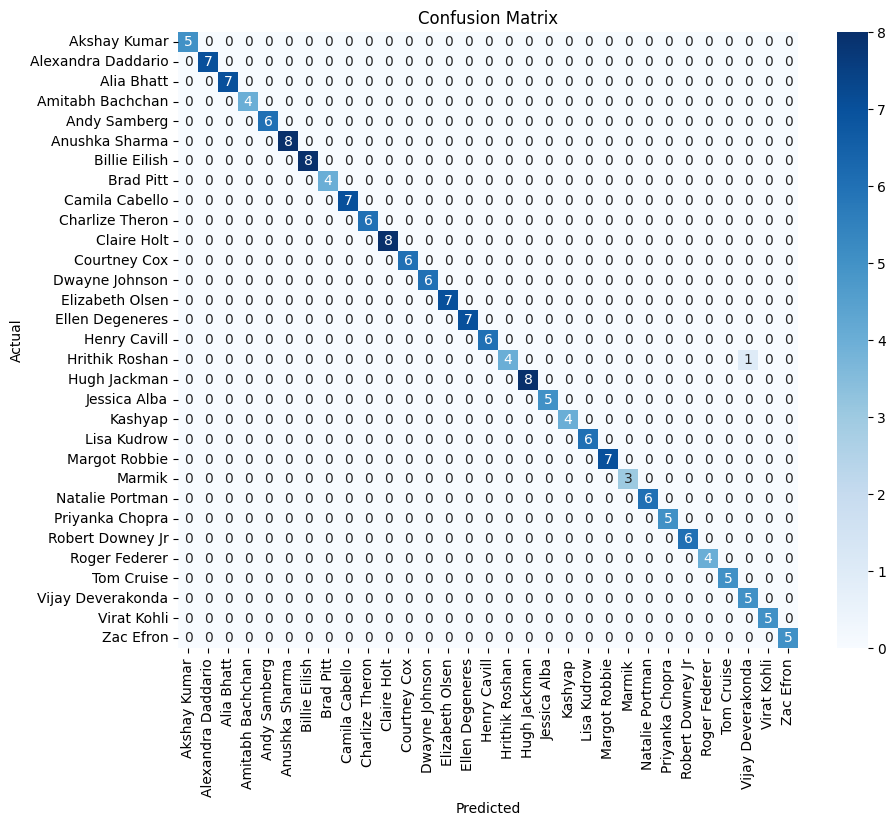

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X = np.load(os.path.join(drive_folder, "embeddings/face_embeddings.npy"))
X = X / np.linalg.norm(X, axis=1, keepdims=True)  # normalize embeddings
y = np.load(os.path.join(drive_folder, "embeddings/labels.npy"))

#in_encoder = Normalizer(norm='l2')
#X = in_encoder.transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)


param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

clf = grid.best_estimator_


y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
import joblib

model_dir = os.path.join(drive_folder, "models")
os.makedirs(model_dir, exist_ok=True)

joblib.dump(clf, os.path.join(model_dir, "svm_classifier.joblib"))
joblib.dump(le, os.path.join(model_dir, "label_encoder.joblib"))

print("Models saved to Google Drive")

Models saved to Google Drive



0: 640x640 1 person, 10.5ms
Speed: 4.4ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Prediction: Hugh Jackman 


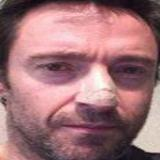

In [58]:
from PIL import Image
from IPython.display import display
from google.colab import files
import random


# Load models
clf = joblib.load(os.path.join(model_dir, "svm_classifier.joblib"))
le = joblib.load(os.path.join(model_dir, "label_encoder.joblib"))

# Upload test image
uploaded = files.upload()

if uploaded:
    # Use uploaded image
    for fname in uploaded:
        img_path = f"/content/{fname}"
        img = cv2.imread(img_path)
        source = "uploaded"
        break
else:
    # Pick random image from dataset
    random_class = random.choice(os.listdir(image_dir))
    class_path = os.path.join(image_dir, random_class)
    random_image = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_image)
    img = cv2.imread(img_path)
    source = f"dataset: {random_class}/{random_image}"

if img is None:
    print("Failed to load image.")
else:
    results = yolo(img)[0]
    if len(results.boxes) == 0:
        print("No face detected.")
    else:
        for box in results.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            face = img[y1:y2, x1:x2]
            if face.shape[0] < 60 or face.shape[1] < 60:
                continue
            face = cv2.resize(face, (160, 160)).astype(np.float32) / 255.0
            face_tensor = torch.tensor(face.transpose(2, 0, 1)).unsqueeze(0).to(device)
            emb = facenet(face_tensor).cpu().detach().numpy()
            emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
            pred = clf.predict(emb)
            name = le.inverse_transform(pred)[0]
            print(f"Prediction: {name} ")
            display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
